# Active Appearance Models - Advanced
The aim of this notebook is to showcase some of the more advanced features that are available for building and fitting AAMs using ``menpo`` and ``menpofit``. 

Note that this notebook assumes that the user has previously gone through the AAMs Basic notebook and he/she is already familiar with the basic AAMs and `Menpo` concepts explained in there. The AAMs Basic notebook shows us how through the use of the `AAMBuilder` and the `LucasKanadeAAMFitter` classes one can easily build and fit basic AAMs using `Menpo`. In reality, `Menpo`'s framework for AAMs is a lot more powerful and we will proceed to show how a large variety of different AAMs and different fitting algorithms can be used by simply specifying the right keyword arguments on the two previous classes.

The complete list of the available keyword arguments for the `AAMBuilder` and their corresponding detailed explanations can be found in Menpo's documentation. Remember that their documentation can be checked at any time from the IPython Notebook by simply running:

In [1]:
from menpofit.aam import HolisticAAM

HolisticAAM??

This notebook is structured in several short sections, each one explaining a different advanced concept related to `Menpo`'s framework for building and fitting AAMs. Specifically:

1. Loading data
2. Building and fitting AAMs with user-defined appearance features
3. Fitting AAMs using different `LucasKanade` based algorithms.
4. Patch-Based AAM building and fitting
5. Fitting AAMs using `Menpo's` Supervised Descent (SD) framework

Note that, in general, these sections are fairly detached from one another and the order in which they are listed bellow is not specifically relevant.

## 1. Loading data

All the following sections will rely on some training and testing data to build and fit their respective AAMs. Once again, we will rely on the training and test sets of the LFPW database for this purpose.

Note that the necessary steps required for acquiring the LFPW database are explained in detail in the AAMs Basics notebook and the user is simply referred to that notebook for this matter.

Let us define the function `load_database()` for loading a set of images, cropping them and converting them to greyscale

In [2]:
%matplotlib inline
from pathlib import Path
import menpo.io as mio

# method to load a database
def load_database(path_to_images, crop_percentage, max_images=None):
    images = []
    # load landmarked images
    for i in mio.import_images(path_to_images, max_images=max_images, verbose=True):
        # crop image
        i = i.crop_to_landmarks_proportion(crop_percentage)
        
        # convert it to grayscale if needed
        if i.n_channels == 3:
            i = i.as_greyscale(mode='luminosity')
            
        # append it to the list
        images.append(i)
    return images

and also define the path to the LFPW database.

Note that the necessary steps required for acquiring the LFPW dataset used throughout this notebook were previously explained in the AAMs Basics notebook and we simply refer the user to that notebook for this matter.

In [3]:
path_to_lfpw = Path('/vol/atlas/databases/lfpw')
path_to_lfpw = Path('/Users/pts08/data/lfpw')

Load and visualize the __training__ images with a crop proportion of 10%:

In [4]:
training_images = load_database(path_to_lfpw / 'trainset' / '*', 0.1)

Importing assets: [==========] 100% (811/811) - done.                           


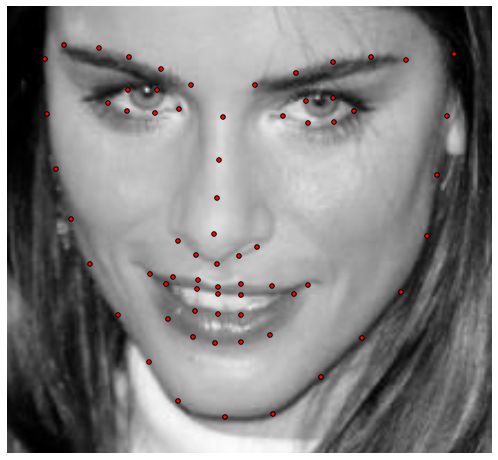

In [5]:
from menpowidgets import visualize_images

visualize_images(training_images)

Load and visualize 5 __test__ images with a crop proportion of 50%:

In [6]:
test_images = load_database(path_to_lfpw / 'testset' / '*', 0.5, max_images=5)

Importing assets: [==========] 100% (5/5) - done.                               


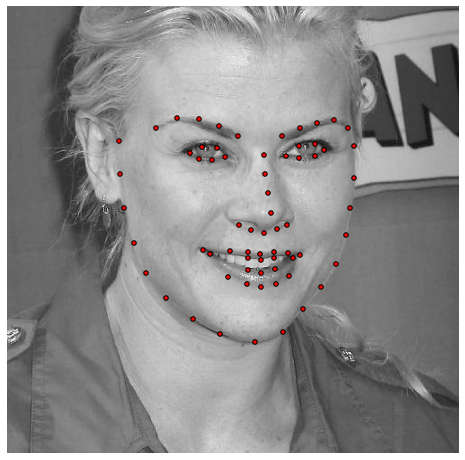

In [7]:
visualize_images(test_images)

## 2. Building and fitting AAMs with user-defined appearance features

One of the most powerful and general characteristics of the `AAMBuilder` class is that it allows the user to build AAMs with arbitrarily user-defined appearance features. Instead of restricting the user to a set of predefined appearance features, `Menpo` allows him/her to define new features (perhaps simple combinations of existing image features supported by Menpo or perhaps completely new (even discriminative!) features designed by the user) and pass them to the `AAMbuilder`.

All that is required is that the user decorates his/her desired feature computation using one of the feature decorators defined in Menpo, i.e. `@ndfeature`, `@imgfeature` or `@winitfeature`. The two first decorators allow the user to define feature computations in terms of simple `numpy` arrays and `Menpo` images. The third decorator supports the definition of features that rely on a cell/block structure (like **HOG** or **SIFT**). Note that, the only computation that needs to be defined by the user defined feature funtion is the pure feature computation over the image pixels; landmarks and mask attached to the image are handled by the previous decorators.

The next cell shows a simple example of such a function, in which **igo** features are computed on an feature image that was already obtained by computing **igo** features:

In [8]:
from menpo.feature import imgfeature, igo

@imgfeature
def custom_double_igo(image):
    return igo(igo(image))

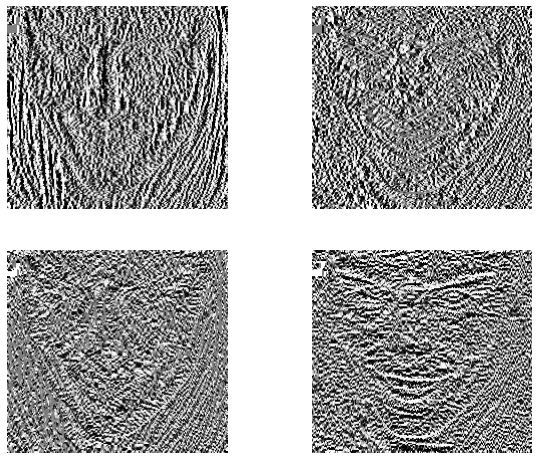

In [9]:
custom_double_igo(training_images[0]).view();

We can now build an AAM using our new feature representation with the following command:

In [10]:
from menpofit.aam import HolisticAAM


aam = HolisticAAM(
    training_images,
    group='PTS',
    verbose=True,
    holistic_features=custom_double_igo, 
    diagonal=120, 
    scales=(0.5, 1.0)
)

- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
                                                              

/Users/pts08/gits/menpofit/menpofit/builder.py:215: MenpoFitModelBuilderWarning: The reference shape passed is not a TriMesh or subclass and therefore the reference frame (mask) will be calculated via a Delaunay triangulation. This may cause small triangles and thus suboptimal warps.
  MenpoFitModelBuilderWarning)
/Users/pts08/gits/menpo/menpo/transform/piecewiseaffine/base.py:102: RuntimeWarning: divide by zero encountered in divide
  d = 1.0/(dot_jj * dot_kk - dot_jk * dot_jk)
/Users/pts08/gits/menpo/menpo/transform/piecewiseaffine/base.py:103: RuntimeWarning: invalid value encountered in multiply
  alpha = (dot_kk * dot_pj - dot_jk * dot_pk) * d
/Users/pts08/gits/menpo/menpo/transform/piecewiseaffine/base.py:104: RuntimeWarning: invalid value encountered in multiply
  beta = (dot_jj * dot_pk - dot_jk * dot_pj) * d
/Users/pts08/gits/menpo/menpo/transform/piecewiseaffine/base.py:52: RuntimeWarning: invalid value encountered in greater_equal
  alpha >= 0, beta >= 0),
/Users/pts08/gits/

In [11]:
print(aam)

Holistic Active Appearance Model
 - Images scaled to diagonal: 120.00
 - Images warped with DifferentiablePiecewiseAffine transform
 - Scales: [0.5, 1.0]
  - Scale 0.5
   - Holistic feature: custom_double_igo
   - 810 appearance components
   - 132 shape components
  - Scale 1.0
   - Holistic feature: custom_double_igo
   - 810 appearance components
   - 132 shape components



Let us now visualize the AAM model

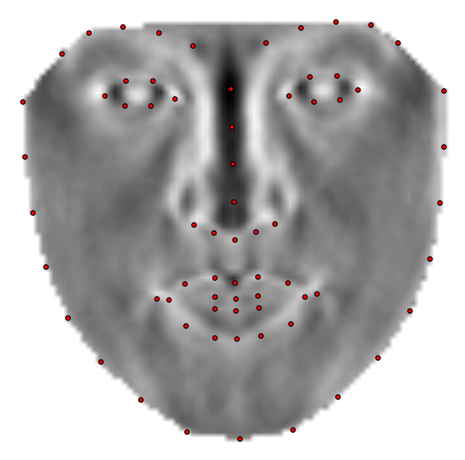

In [12]:
aam.view_aam_widget()

The trained AAM can be used to fit the loaded testing images using the following commands:

In [13]:
from menpofit.aam import LucasKanadeAAMFitter

fitter = LucasKanadeAAMFitter(aam, n_shape=[6, 12], n_appearance=0.5)

In [14]:
fitting_results = []

for i in test_images:
    # obtain original landmarks
    gt_s = i.landmarks['PTS'].lms
    
    # generate perturbed landmarks
    s = fitter.perturb_from_bb(gt_s, gt_s.bounding_box())
    
    # fit image
    fr = fitter.fit_from_shape(i, s, gt_shape=gt_s) 
    fitting_results.append(fr)
    
    print(fr)

Initial error: 0.0428
Final error: 0.0133
Initial error: 0.0333
Final error: 0.0157
Initial error: 0.0720
Final error: 0.0793
Initial error: 0.0533
Final error: 0.0183
Initial error: 0.0508
Final error: 0.0349


Let's have a look at the fitting results:

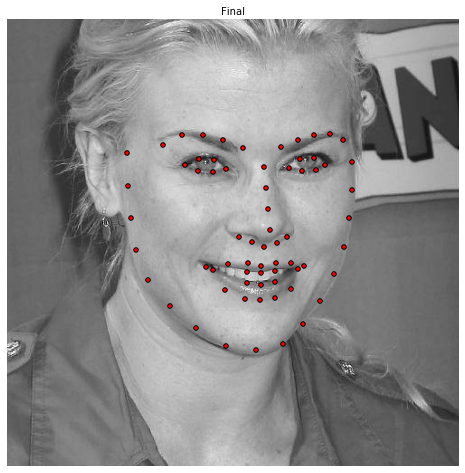

In [15]:
from menpowidgets import visualize_fitting_result

visualize_fitting_result(fitting_results)

## 4. Patch-Based AAM building and fitting

All the previous AAM examples were using a holistic appearance representation, i.e. the whole face was employed as an appearance vector. Herein, we show how to build and fit a patch-based AAM. This means that the appearance representation consists of small patches extracted around each of the landmark points.

The patch-based AAM builder, `PatchAAM`, has the same parameters as the `HolisticAAM`, with the addition of the `patch_shape` parameter. We'll train such an AAM using IGOs with double angles as feature representation:

In [16]:
from menpofit.aam import PatchAAM
from menpo.feature import double_igo

patch_based_aam = PatchAAM(
    training_images,
    group='PTS',
    verbose=True,
    holistic_features=double_igo, 
    diagonal=120, 
    scales=(0.5, 1.0)
)

- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
                                                              

In [17]:
print(patch_based_aam)

Patch-based Active Appearance Model
 - Images scaled to diagonal: 120.00
 - No image warping performed
 - Scales: [0.5, 1.0]
  - Scale 0.5
   - Holistic feature: igo
   - 810 appearance components
   - 132 shape components
   - Patch shape: (17, 17)
  - Scale 1.0
   - Holistic feature: igo
   - 810 appearance components
   - 132 shape components
   - Patch shape: (17, 17)



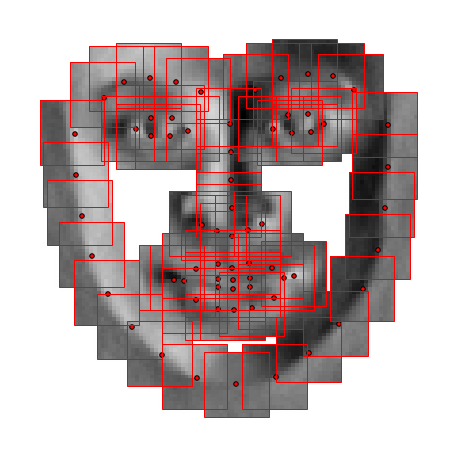

In [18]:
patch_based_aam.view_aam_widget()

The fitting of the trained Patch-Based AAM can use any of the algorithms of the `LucasKanadeAAMFitter` presented in the previous section as:

In [19]:
fitter = LucasKanadeAAMFitter(patch_based_aam, 
                              n_shape=[3, 12], 
                              n_appearance=50)

In [20]:
fitting_results = []

for i in test_images:
    # obtain original landmarks
    gt_s = i.landmarks['PTS'].lms
    
    # generate perturbed landmarks
    s = fitter.perturb_from_bb(gt_s, gt_s.bounding_box())
    
    # fit image
    fr = fitter.fit_from_shape(i, s, gt_shape=gt_s) 
    fitting_results.append(fr)
    
    print(fr)

Initial error: 0.0328
Final error: 0.0131
Initial error: 0.0679
Final error: 0.0137
Initial error: 0.0432
Final error: 0.0209
Initial error: 0.0520
Final error: 0.0196
Initial error: 0.0631
Final error: 0.0238


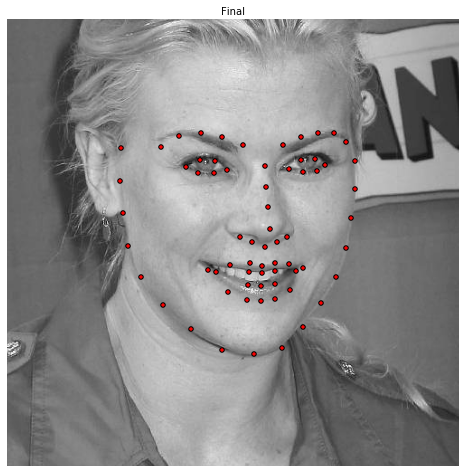

In [21]:
visualize_fitting_result(fitting_results)